## Importing the required libraries

In [64]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import os
from keras import regularizers

In [65]:
%pylab inline
import pandas as pd
import librosa
import glob 
from keras.callbacks import EarlyStopping
from pathlib import Path

Populating the interactive namespace from numpy and matplotlib


C:\Users\20194998\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Link to dataset

https://tuenl.sharepoint.com/sites/gad_cbo/JPC/MC/ESA%20PDEng%20ST%20Project/Forms/AllItems.aspx?viewid=235c9f56%2Db4dc%2D418e%2D8800%2Dd0cde58fff30&id=%2Fsites%2Fgad%5Fcbo%2FJPC%2FMC%2FESA%20PDEng%20ST%20Project%2FModelsAndData%2FAudio%2FDevelopment%2Fdata%2Ftone%5Fcnn%5Fhappy%5Fangry%5Fdataset

In [66]:
# Walking a directory tree and getting the names and directories of the train and test files 
mydiclist={}
curr_path = os.getcwd()
crr_path = Path(curr_path)
parent_path = crr_path.parent
base_path= str(parent_path)+'\\data\\tone_cnn_8_emotions_dataset\\'
for dirpath, dirnames, files in os.walk(base_path):
    for file_name in files:
        if file_name.endswith('.wav'):
            mydiclist[file_name]= dirpath

In [67]:
#from pathlib import Path
#curr_path = os.getcwd()
#crr_path = Path(curr_path)
#parent_path = crr_path.parent
#path = str(parent_path) +  '\\Actor_01\\'
#mylist= os.listdir(path)
#print(type(mylist))

## Setting the labels

In [68]:
feeling_list=[]
       
# (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).        
        
feeling_list=[]
for key in mydiclist:    
    if key[6:-16]=='01':
        feeling_list.append('neutral')
    if key[6:-16]=='02':
        feeling_list.append('calm')
    elif key[6:-16]=='03':
        feeling_list.append('Happy')
    elif key[6:-16]=='04':
        feeling_list.append('sad')
    elif key[6:-16]=='05':
        feeling_list.append('angry')
    elif key[6:-16]=='06':
        feeling_list.append('fearful')
    elif key[6:-16]=='07': 
        feeling_list.append('disgust')
    elif key[6:-16]=='08': 
        feeling_list.append('surprised')
   

In [69]:
labels = pd.DataFrame(feeling_list)

In [70]:
labels[:]

,0
0,neutral
1,neutral
2,neutral
3,neutral
4,calm
...,...
1435,surprised
1436,surprised
1437,surprised
1438,surprised


## Getting the features of audio files using librosa

In [71]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for key in mydiclist:
    X, sample_rate = librosa.load(mydiclist[key]+'\\'+key, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13),
                        axis=0)
    feature = mfccs
    #[float(i) for i in feature]
    df.loc[bookmark] = [feature]
    bookmark=bookmark+1    

In [72]:
#df = pd.DataFrame(columns=['feature'])
#bookmark=0
#for index,y in enumerate(mylist):
#    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
#        X, sample_rate = librosa.load(path+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
#        sample_rate = np.array(sample_rate)
#        mfccs = np.mean(librosa.feature.mfcc(y=X, 
#                                            sr=sample_rate, 
#                                            n_mfcc=13),
#                        axis=0)
#        feature = mfccs
#        #[float(i) for i in feature]
#        df.loc[bookmark] = [feature]
#        bookmark=bookmark+1        

In [73]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [74]:
newdf = pd.concat([df3,labels], axis=1)

In [75]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [76]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
302,-58.038567,-56.945641,-56.222530,-58.507347,-60.056675,-61.237431,-61.514500,-59.097778,-59.701725,-59.199768,...,-60.093227,-59.682449,-59.239323,-58.234951,-58.351200,-58.628315,-56.472054,-57.995502,-61.422791,neutral
635,-41.384239,-41.737446,-41.841331,-41.788242,-41.841331,-41.841331,-41.841331,-41.129440,-39.942932,-40.544277,...,-24.796743,-26.133371,-30.697853,-32.224312,-32.934696,-31.673471,-32.869686,-34.093655,-35.078102,angry
209,-52.493233,-52.493233,-52.493233,-52.493233,-52.493233,-52.493233,-52.493233,-52.493233,-52.493233,-52.493233,...,-52.493233,-52.493233,-52.444584,-52.493233,-52.493233,-52.493233,-52.484932,-52.034988,-51.387383,angry
604,-61.856262,-59.841209,-59.137161,-59.362698,-59.033707,-58.838234,-58.639858,-58.646053,-59.653038,-62.066002,...,-56.521854,-58.689701,-58.885868,-57.405605,-55.915184,-54.769287,-56.704975,-56.083965,-56.884750,calm
966,-49.250637,-47.740860,-49.672993,-50.764851,-51.801365,-51.357605,-51.992981,-51.296574,-49.914944,-51.691490,...,-45.861893,-46.302067,-49.884659,-48.919327,-49.577133,-49.001667,-47.466061,-47.603310,-46.976017,calm
734,-57.354610,-56.764095,-56.161160,-57.752335,-57.455196,-55.104424,-56.519279,-61.743305,-62.724113,-60.338741,...,-61.687904,-62.345596,-59.201382,-57.919853,-57.302345,-57.860756,-59.635963,-59.327217,-62.622055,Happy
793,-55.912144,-55.912144,-55.912144,-55.912144,-55.912144,-55.912144,-55.912144,-55.912144,-55.912144,-55.912144,...,-54.049412,-53.750706,-53.949821,-53.864204,-55.672630,-55.545002,-55.861759,-55.912144,-55.912144,Happy
409,-60.671242,-61.501102,-60.820377,-60.948307,-61.316853,-60.825981,-60.520775,-59.193661,-59.009708,-59.532661,...,-21.707048,-21.717684,-22.771929,-22.873360,-21.651493,-20.168156,-20.363548,-20.848034,-18.700886,disgust
883,-49.825691,-49.267822,-49.619240,-50.928787,-51.196487,-50.622883,-51.028446,-50.076561,-50.141853,-51.056152,...,-46.926853,-46.416359,-45.444965,-45.200439,-46.972042,-47.902260,-48.657658,-47.372757,-48.934853,fearful
1304,-55.164009,-55.861851,-56.465736,-55.386902,-55.355251,-55.873501,-56.220478,-54.905071,-54.357304,-52.946331,...,-51.844704,-55.881474,-54.258457,-51.195881,-50.088661,-51.145996,-53.190781,-54.721615,-53.742119,disgust


In [77]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [78]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [79]:
train[10:20]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
314,-63.488754,-60.576641,-56.701763,-56.070492,-58.910580,-61.154972,-59.071247,-56.579098,-55.198971,-56.515549,...,-59.535545,-55.875542,-54.532017,-55.293648,-55.092278,-54.403172,-56.776207,-59.719543,-60.744717,Happy
215,-49.626648,-49.626648,-49.626648,-49.626648,-49.626648,-49.626648,-49.626648,-49.626648,-49.626648,-49.626648,...,-41.813663,-44.129826,-46.296909,-47.937187,-48.107651,-47.130939,-49.147984,-49.498745,-48.562721,angry
546,-52.358807,-51.610115,-50.046631,-49.424397,-51.406414,-51.462032,-50.192711,-51.117050,-52.238796,-51.404472,...,-48.206566,-49.825951,-48.717484,-47.780880,-49.512329,-49.161598,-46.813667,-46.451687,-45.739906,calm
1194,-66.638000,-66.638000,-66.638000,-66.638000,-66.638000,-66.638000,-66.638000,-66.638000,-66.638000,-66.638000,...,-64.825310,-66.289062,-66.707939,-66.696861,-66.638000,-65.720284,-65.538300,-66.403282,-66.623062,surprised
657,-52.084724,-52.463596,-52.680771,-50.508888,-50.079182,-49.545101,-49.456711,-51.206169,-50.610317,-49.752174,...,-52.680771,-51.061298,-50.774620,-51.132248,-49.962582,-50.319702,-51.773911,-52.370956,-51.886013,surprised
677,-48.638100,-48.638100,-48.638100,-48.638100,-48.638100,-48.638100,-48.638100,-48.076477,-47.975407,-47.726406,...,-34.005039,-30.143806,-28.844574,-28.764626,-29.490532,-29.049360,-27.577091,-21.164640,-14.801329,Happy
188,-66.264893,-66.264893,-66.264893,-66.264893,-66.264893,-66.264893,-66.264893,-66.264893,-66.264893,-67.042038,...,-40.741112,-41.120735,-40.283394,-39.689163,-39.673252,-40.182980,-41.530998,-36.970688,-30.308895,calm
370,-60.638588,-60.965298,-62.446186,-64.448090,-66.764763,-67.361618,-67.469635,-66.982574,-66.915482,-67.386955,...,-31.947651,-33.441402,-32.761349,-32.913437,-33.728172,-33.302490,-32.801800,-29.852169,-27.932539,calm
64,-65.707649,-65.707649,-63.114719,-61.518997,-61.097141,-63.424599,-63.720066,-56.854614,-55.168972,-54.639999,...,-39.792141,-40.613159,-41.209202,-41.439201,-43.994278,-49.399620,-50.591599,-49.144051,-48.705654,calm
13,-60.369045,-60.083717,-60.978924,-60.952457,-60.982483,-60.983948,-60.981255,-60.981255,-60.981255,-60.249615,...,-49.848366,-49.632915,-55.102585,-55.481716,-52.952229,-51.401585,-54.072971,-52.639565,-52.664181,Happy


In [80]:
trainfeatures = train.iloc[:, :-1]

In [81]:
trainlabel = train.iloc[:, -1:]
print(shape(trainlabel))

(1142, 1)


In [82]:
testfeatures = test.iloc[:, :-1]

In [83]:
testlabel = test.iloc[:, -1:]

In [84]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)
print(y_train)
lb = LabelEncoder()

nb_classes = 8 
encoder = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train), nb_classes)
y_test = np_utils.to_categorical(lb.fit_transform(y_test), nb_classes)

numpy.save('encoder.npy', lb.classes_)

[['angry']
 ['angry']
 ['calm']
 ...
 ['neutral']
 ['fearful']
 ['calm']]


C:\Users\20194998\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [85]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [86]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [87]:
X_train.shape

(1142, 216)

## Changing dimension for CNN model

In [88]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [89]:
model = Sequential()
#filters, kernel_size, strides=1, padding='valid', data_format='channels_last',

model.add(Conv1D(256, 5,padding='same', input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax')) #softmax as we are doing multiclass classification
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [90]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_5 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_6 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 27, 128)          

In [92]:
model.compile(loss=
             'categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
#tf.keras.losses.SparseCategoricalCrossentropy()
#'categorical_crossentropy'

In [93]:
#es = EarlyStopping(monitor='loss', mode='min')
#cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test), callbacks=[es])

In [94]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=100, validation_data=(x_testcnn, y_test))

Epoch 1/100
72/72 [==============================] - 7s 103ms/step - loss: 2.1563 - accuracy: 0.1349 - val_loss: 2.0799 - val_accuracy: 0.1208
Epoch 2/100
72/72 [==============================] - 7s 96ms/step - loss: 2.0627 - accuracy: 0.1646 - val_loss: 2.0453 - val_accuracy: 0.1846
Epoch 3/100
72/72 [==============================] - 7s 93ms/step - loss: 2.0382 - accuracy: 0.1970 - val_loss: 2.0162 - val_accuracy: 0.1544
Epoch 4/100
72/72 [==============================] - 6s 89ms/step - loss: 2.0013 - accuracy: 0.2277 - val_loss: 1.9953 - val_accuracy: 0.2450
Epoch 5/100
72/72 [==============================] - 7s 101ms/step - loss: 1.9748 - accuracy: 0.2417 - val_loss: 1.9334 - val_accuracy: 0.2886
Epoch 6/100
72/72 [==============================] - 9s 121ms/step - loss: 1.9139 - accuracy: 0.2723 - val_loss: 1.9101 - val_accuracy: 0.2584
Epoch 7/100
72/72 [==============================] - 10s 133ms/step - loss: 1.8996 - accuracy: 0.2837 - val_loss: 1.9099 - val_accuracy: 0.2617
E

72/72 [==============================] - 8s 106ms/step - loss: 0.2277 - accuracy: 0.9422 - val_loss: 2.3300 - val_accuracy: 0.4161
Epoch 59/100
72/72 [==============================] - 6s 86ms/step - loss: 0.2330 - accuracy: 0.9378 - val_loss: 2.4540 - val_accuracy: 0.4128
Epoch 60/100
72/72 [==============================] - 6s 89ms/step - loss: 0.1824 - accuracy: 0.9597 - val_loss: 2.3665 - val_accuracy: 0.4362
Epoch 61/100
72/72 [==============================] - 6s 80ms/step - loss: 0.1854 - accuracy: 0.9545 - val_loss: 2.4461 - val_accuracy: 0.4195
Epoch 62/100
72/72 [==============================] - 6s 81ms/step - loss: 0.1472 - accuracy: 0.9702 - val_loss: 2.4600 - val_accuracy: 0.3960
Epoch 63/100
72/72 [==============================] - 6s 82ms/step - loss: 0.1640 - accuracy: 0.9658 - val_loss: 2.6525 - val_accuracy: 0.4262
Epoch 64/100
72/72 [==============================] - 6s 81ms/step - loss: 0.1300 - accuracy: 0.9816 - val_loss: 2.6015 - val_accuracy: 0.4060
Epoch 65/10

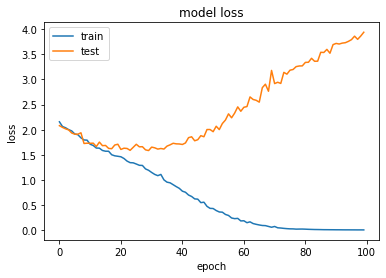

In [95]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [96]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at D:\Projects\ESA\audio-sentiment-analysis\prototypes\saved_models\Emotion_Voice_Detection_Model.h5 


In [97]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [98]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 43.96%


## Predicting emotions on the test data

In [42]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

9/9 [==============================] - 0s 17ms/step


In [43]:
preds

array([[0.16879869, 0.02109269, 0.183692  , ..., 0.10259657, 0.22244832,
        0.09629356],
       [0.23596318, 0.10923008, 0.0417158 , ..., 0.03229681, 0.06905668,
        0.26862612],
       [0.10233006, 0.61442405, 0.06422991, ..., 0.01306609, 0.02684782,
        0.05012532],
       ...,
       [0.22926757, 0.07640006, 0.06560344, ..., 0.02389086, 0.18495321,
        0.16268146],
       [0.1790455 , 0.37358436, 0.04318428, ..., 0.03698333, 0.04661356,
        0.16054548],
       [0.24608195, 0.08227899, 0.10976911, ..., 0.05919385, 0.18360728,
        0.14945805]], dtype=float32)

In [44]:
preds1=preds.argmax(axis=1)

In [45]:
preds1

array([6, 7, 1, 6, 0, 7, 1, 2, 1, 0, 2, 3, 0, 7, 0, 7, 3, 3, 2, 2, 1, 3,
       7, 7, 0, 2, 7, 2, 3, 6, 7, 2, 6, 2, 6, 7, 0, 0, 6, 1, 7, 0, 0, 3,
       6, 6, 3, 2, 1, 1, 6, 2, 7, 3, 0, 7, 3, 0, 0, 2, 7, 2, 0, 3, 6, 2,
       3, 3, 0, 0, 7, 0, 7, 6, 2, 1, 0, 0, 3, 0, 6, 1, 7, 2, 2, 0, 0, 2,
       7, 7, 6, 0, 7, 0, 7, 7, 1, 2, 2, 0, 6, 0, 2, 3, 2, 3, 7, 0, 0, 2,
       7, 0, 2, 2, 0, 6, 6, 2, 0, 0, 6, 0, 3, 0, 0, 1, 0, 1, 2, 1, 0, 2,
       2, 2, 7, 2, 6, 0, 0, 3, 2, 0, 3, 0, 6, 0, 7, 0, 1, 2, 0, 3, 6, 0,
       3, 2, 2, 0, 2, 7, 0, 2, 2, 7, 2, 0, 0, 7, 0, 2, 2, 0, 3, 0, 1, 7,
       7, 7, 3, 7, 0, 2, 3, 2, 0, 7, 1, 0, 2, 2, 0, 0, 0, 2, 3, 6, 6, 7,
       2, 0, 6, 2, 0, 3, 2, 7, 0, 0, 2, 2, 0, 3, 0, 3, 7, 1, 0, 6, 0, 0,
       0, 2, 0, 0, 0, 7, 2, 0, 0, 0, 6, 2, 0, 2, 0, 0, 0, 3, 7, 0, 7, 0,
       6, 6, 0, 7, 0, 0, 2, 3, 1, 0, 6, 0, 2, 2, 2, 0, 0, 0, 6, 7, 6, 3,
       0, 0, 2, 7, 3, 3, 1, 0, 0, 7, 0, 2, 0, 0, 6, 3, 7, 7, 3, 2, 7, 0,
       1, 0], dtype=int64)

In [46]:
abc = preds1.astype(int).flatten()

In [47]:
predictions = (lb.inverse_transform((abc)))

In [48]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf

,predictedvalues
0,sad
1,surprised
2,angry
3,sad
4,Happy
...,...
283,calm
284,surprised
285,Happy
286,angry


In [49]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [50]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf

,actualvalues
0,Happy
1,angry
2,angry
3,sad
4,fearful
...,...
283,Happy
284,fearful
285,fearful
286,angry


In [51]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [52]:
finaldf[0:4]

,actualvalues,predictedvalues
0,Happy,sad
1,angry,surprised
2,angry,angry
3,sad,sad


In [53]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
Happy,39
angry,42
calm,33
disgust,41
fearful,48
neutral,18
sad,35
surprised,32


In [54]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
Happy,96
angry,20
calm,61
disgust,34
sad,31
surprised,46


In [55]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

## you could find this track on below link:

https://tuenl.sharepoint.com/sites/gad_cbo/JPC/MC/ESA%20PDEng%20ST%20Project/Forms/AllItems.aspx?viewid=235c9f56%2Db4dc%2D418e%2D8800%2Dd0cde58fff30&id=%2Fsites%2Fgad%5Fcbo%2FJPC%2FMC%2FESA%20PDEng%20ST%20Project%2FModelsAndData%2FAudio%2FDevelopment%2Fdata%2Ftone%5Fcnn%5Fhappy%5Fangry%5Fdataset%5Fsample%5Fprediction%5Ftracks

In [60]:
# Walking a directory tree and getting the names and directories of the prediction files
mydiclist={}
curr_path = os.getcwd()
crr_path = Path(curr_path)
parent_path = crr_path.parent
base_path= str(parent_path)+'\\data\\tone_cnn_prediction_dataset\\'
for dirpath, dirnames, files in os.walk(base_path):
    for file_name in files:
        if file_name.endswith('.wav'):
            mydiclist[file_name]= dirpath

    
#X, sample_rate = librosa.load(str(base_path) +'\\Recording_hateYou.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
#sample_rate = np.array(sample_rate)
#mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
#featurelive = mfccs
#livedf2 = featurelive

In [61]:
for key in mydiclist:
    X, sample_rate = librosa.load(mydiclist[key]+'\\'+key, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    featurelive = mfccs
    livedf2 = featurelive
    livedf2= pd.DataFrame(data=livedf2)
    livedf2 = livedf2.stack().to_frame().T
    twodim= np.expand_dims(livedf2, axis=2)
    livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)
    livepreds1=livepreds.argmax(axis=1)
    liveabc = livepreds1.astype(int).flatten()
    livepredictions = (lb.inverse_transform((liveabc)))
    print(key+"  :  "+ livepredictions)
    

1/1 [==============================] - 0s 2ms/step
['multiple_silence_trimmed.wav  :  fearful']
1/1 [==============================] - 0s 997us/step
['Recording_hateYou.wav  :  surprised']
